# Power Calculation

A power calculation involves four variables: effect size, sample size, statistical power, and significance level. (A quick primer on how these four variables interact is available https://cran.r-project.org/web/packages/pwr/vignettes/pwr-vignette.html.)

We will vary the effect size through a range of possibilities to determine the Minimum Detectable Effect (MDE), while maintaining the other three variables as constant. Specifically, we set:
- Sample Size: pre-pandemic average of 808 claimants / week, 150 of which are randomized into treatment
- Statistical Power: 0.8
- Significance Level: 0.05

For additional detail on power calculations, please refer to [this primer](https://egap.org/resource/10-things-to-know-about-statistical-power/) on power calculations provided from EGAP.

# Hypothesis

The calculation involves 4 hypotheses specified as a one-sided $t$-test as outlined by **section C.3** of the Pre-Analysis Plan. Each category is generated as follows:
- Percent change in annual earnings:  
Generated using a normal distribution by varying the mean between 30,000 - 60,000, and a standard deviation of $3,000. The range is between the state's minumum income and the median income of an individual. 

- Percentage point change in total employment:
Generated using a binomial distribution with the assumed reemployment rate ranging from 50% - 70%. By definition, everyone is assumed to be unemployed at the beginning of the study.

- Percent change in hour to pay ratio:
Generated using an exponential distribution with scaling parameter between 0.5 - 3.0. This assumes that a majority of the participants make very close to minimum wage.

- Percent change in total weeks receiving unemployment.
Generated using the poisson distribution with scaling parameter 0.5 weeks ~ 6 weeks. 

# Multiple Hypothesis Adjustment

As we are analyzing these four hypotheses on the same data, our results require a multiple-hypothesis adjustment.  
Multiple hypothesis adjustment typically takes one of two forms: controlling the False Discovery Rate (FDR) or controlling the more conservative Family-Wise Error Rate (FWER). 

The false discovery rate (FDR) is the expected proportion of false rejections out of all rejections.  
The family-wise error rate (FWER) is the probability of making any false positives at all.

This analysis opts to control for the FWER because all four hypotheses are extremely correlated. Specifically, an individual's "annual earnings" (Hypothesis 1) can be directly translated into an individual's "hour to pay ratio" (Hypothesis 3), while an individual's "employment status" (Hypothesis 2) directly contributes to their "total weeks receiving unemployment" (Hypothesis 4). Therefore, the set up of our hypothesis only enables a clear causal explanation when we can be confident that all four hypotheses are statistically significant. We were also confident that the large sample size will enable us to demonstrate statistical significance despite the more conservative
The FWER adjustment is implemented using the Bonferroni-Holm method. For specifics of how the method is implemented, please refer to `In[7]`, particularly the `apply_holm=True` option.

* For additional detail on power calculations, please refer to this [Wikipedia page on the method](https://en.wikipedia.org/wiki/Holm%E2%80%93Bonferroni_method).    
* For further exploration on multiple hypothesis correction, please refer to this lecture offered by [Joshua Loftus at Stanford](https://statweb.stanford.edu/~joftius/slides/testing.pdf)


In [1]:
from concurrent.futures import ThreadPoolExecutor
from itertools import repeat
from typing import Optional

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats as st
from tqdm.notebook import tqdm

from dlt import power_analysis_utils as utils

sns.set_theme(context="notebook", style="darkgrid")
sns.set(rc={"figure.figsize": (11.7, 8.27)})

In [2]:
# Store values as mean and sd
# Reference Historical data document for how these numbers were generated
pre_pandemic_avg = [808.0813397129186, 395.62975369136336]
pandemic_avg = [4958.881578947368, 4208.843733432751]

In [3]:
# Constants
study_number_of_weeks = int(52 * 1.5)  # 1.5 years
qt_number_of_weeks = study_number_of_weeks  # generate participants for all sample

# Variables
threshold_of_significance = 0.05

In [4]:
check_length = 20

# Set Effect Sizes for each variable:
inc_base_rates = np.linspace(30_000, 60_000, check_length)
emp_base_rates = np.linspace(0.5, 0.75, check_length)
pay_ratio_lambdas = np.linspace(0.5, 3, check_length)
qt_unemp_base_rates = np.linspace(0.5, 6, check_length)
effect_sizes = np.linspace(0.01, 0.08, check_length)

# Group the inputs together to facilitate sample generation
input_list = list(
    zip(inc_base_rates, emp_base_rates, pay_ratio_lambdas, qt_unemp_base_rates)
)

In [5]:
def gen_sample(
    effect_size: float,
    inc_base_rate: float,
    emp_base_rate: float = 0.8,
    pay_ratio_lambda: float = 0.5,
    qt_unemp_lambda: float = 3,
    number_of_weeks: int = 13,
    number_of_eligibles_by_week: int = 808,
    number_treat_per_week: int = 150,
    seed: Optional[int] = None,
) -> pd.DataFrame:
    """
    Generate sample. This process assumes that there are `number_of_eligibles_by_week`
    people who will potentially be in the sample. Of these `number_treat_per_week`
    will be enrolled into the treatment at random, the rest will be controls.

    The sample is generated for `number_of_weeks` weeks.

    We return a single data frame with the following utility columns:
        * `cohort` to which week the generated person belongs
        * `is_treated` whether the generated person was in the treatment or control group

    Args:
        effect_size: used to define the treatment effect, which modifies the mean of generated data
        inc_base_rate: changes annual income data generation
        emp_base_rate: changes employment outcome data generation
        pay_ratio_lambda: changes the pay ratio outcome data generation
        qt_unemp_lambda: changes the number of weeks on unemployment data generation
        number_of_weeks: the number of weeks for which we will generate a sample
    """
    # Assume all eligible enrolled
    number_control_per_week = number_of_eligibles_by_week - number_treat_per_week

    ## Generate data for each measure
    inc_treated_df, inc_control_df = utils.gen_annual_income(
        number_control_per_week,
        effect_size,
        inc_base_rate=inc_base_rate,
        number_of_weeks=number_of_weeks,
        number_treat_per_week=number_treat_per_week,
        seed=seed,
    )
    emp_treated_df, emp_control_df = utils.gen_employment(
        number_control_per_week,
        effect_size,
        emp_base_rate=emp_base_rate,
        number_of_weeks=number_of_weeks,
        number_treat_per_week=number_treat_per_week,
        seed=seed,
    )
    pay_ratio_treated_df, pay_ratio_control_df = utils.gen_pay_ratio(
        number_control_per_week,
        effect_size,
        pay_ratio_lambda=pay_ratio_lambda,
        number_of_weeks=number_of_weeks,
        number_treat_per_week=number_treat_per_week,
        seed=seed,
    )
    unemp_treated_df, unemp_control_df = utils.gen_weeks_on_unemployment(
        number_control_per_week,
        effect_size,
        qt_unemp_lambda=qt_unemp_lambda,
        number_of_weeks=number_of_weeks,
        number_treat_per_week=number_treat_per_week,
        seed=seed,
    )

    # collect all information generated for treatment arm
    treated_df = pd.concat(
        [inc_treated_df, emp_treated_df, pay_ratio_treated_df, unemp_treated_df],
        axis=1,
    )
    # collect all information generated for control arm
    control_df = pd.concat(
        [inc_control_df, emp_control_df, pay_ratio_control_df, unemp_control_df],
        axis=1,
    )

    # concatenate treat_df and control_df, and define cohorts.
    df = pd.concat(
        [
            utils.gen_cohorts(
                treated_df, cohort_unit=number_treat_per_week, is_treated=True
            ),
            utils.gen_cohorts(
                control_df,
                cohort_unit=number_control_per_week,
                is_treated=False,
            ),
        ]
    )
    # Generate `inc_diff` for easier t-test
    df["inc_diff"] = df["inc_outcome"] - df["inc_initial"]
    return df

In [6]:
def generate_ttest(
    inc_base_rate: float,
    emp_base_rate: float,
    pay_ratio_lambda: float,
    qt_unemp_base_rate: float,
    qt_number_of_weeks: int = 78,
    effect_sizes=np.arange(0.01, 0.20, 0.01),
    threshold_of_significance=0.05,
    num_runs: int = 100,
    apply_holm: bool = False,
    apply_by: bool = False,
) -> pd.DataFrame:

    """
    Generates power calculation for simple t-test for each of the four measures.

    Args:
        inc_base_rate: changes annual income data generation
        emp_base_rate: changes employment outcome data generation
        pay_ratio_lambda: changes the pay ratio outcome data generation
        qt_unemp_lambda: changes the number of weeks on unemployment data generation
        qt_number_of_weeks: changes the number quarters the data is generated for
        effect_sizes: Variations of effect sizes
        threshold_of_significance: Defaults to 0.05
    """
    powers = []
    for seed, effect_size in tqdm(list(enumerate(effect_sizes, 12839))):

        inc_pvalues = []
        employment_pvalues = []
        pay_ratio_pvalues = []
        wks_unemp_pvalues = []
        df = gen_sample(
            effect_size=effect_size,
            inc_base_rate=inc_base_rate,
            emp_base_rate=emp_base_rate,
            pay_ratio_lambda=pay_ratio_lambda,
            qt_unemp_lambda=qt_unemp_base_rate,
            number_of_weeks=qt_number_of_weeks * num_runs,
            seed=seed,
        )

        df["group"] = df["cohort"] // qt_number_of_weeks
        ttest_stats = (
            df.groupby(["group", "is_treated"])[
                ["inc_diff", "employment", "pay_ratio", "wks_unemp"]
            ]
            .agg(["mean", "std", "size"])
            .reset_index()
            .sort_values(by=["group", "is_treated"])
        )

        col_to_list = dict(
            [
                ("inc_diff", inc_pvalues),
                ("employment", employment_pvalues),
                ("pay_ratio", pay_ratio_pvalues),
                ("wks_unemp", wks_unemp_pvalues),
            ]
        )

        if not apply_holm and not apply_by:
            # Just return the threshold at the base level of significance passed
            for col, lst in col_to_list.items():

                result = st.ttest_ind_from_stats(
                    ttest_stats.iloc[
                        ::2,
                        (ttest_stats.columns.get_level_values(0) == col)
                        & (ttest_stats.columns.get_level_values(1) == "mean"),
                    ].values,
                    ttest_stats.iloc[
                        ::2,
                        (ttest_stats.columns.get_level_values(0) == col)
                        & (ttest_stats.columns.get_level_values(1) == "std"),
                    ].values,
                    ttest_stats.iloc[
                        ::2,
                        (ttest_stats.columns.get_level_values(0) == col)
                        & (ttest_stats.columns.get_level_values(1) == "size"),
                    ].values,
                    ttest_stats.iloc[
                        1::2,
                        (ttest_stats.columns.get_level_values(0) == col)
                        & (ttest_stats.columns.get_level_values(1) == "mean"),
                    ].values,
                    ttest_stats.iloc[
                        1::2,
                        (ttest_stats.columns.get_level_values(0) == col)
                        & (ttest_stats.columns.get_level_values(1) == "std"),
                    ].values,
                    ttest_stats.iloc[
                        1::2,
                        (ttest_stats.columns.get_level_values(0) == col)
                        & (ttest_stats.columns.get_level_values(1) == "size"),
                    ].values,
                    equal_var=False,
                )
                lst.extend(result.pvalue < threshold_of_significance)

        elif apply_holm or apply_by:
            # Apply the Holm correction to the base p-values
            local_pvalues = {}
            for col in col_to_list:
                result = st.ttest_ind_from_stats(
                    ttest_stats.iloc[
                        ::2,
                        (ttest_stats.columns.get_level_values(0) == col)
                        & (ttest_stats.columns.get_level_values(1) == "mean"),
                    ].values,
                    ttest_stats.iloc[
                        ::2,
                        (ttest_stats.columns.get_level_values(0) == col)
                        & (ttest_stats.columns.get_level_values(1) == "std"),
                    ].values,
                    ttest_stats.iloc[
                        ::2,
                        (ttest_stats.columns.get_level_values(0) == col)
                        & (ttest_stats.columns.get_level_values(1) == "size"),
                    ].values,
                    ttest_stats.iloc[
                        1::2,
                        (ttest_stats.columns.get_level_values(0) == col)
                        & (ttest_stats.columns.get_level_values(1) == "mean"),
                    ].values,
                    ttest_stats.iloc[
                        1::2,
                        (ttest_stats.columns.get_level_values(0) == col)
                        & (ttest_stats.columns.get_level_values(1) == "std"),
                    ].values,
                    ttest_stats.iloc[
                        1::2,
                        (ttest_stats.columns.get_level_values(0) == col)
                        & (ttest_stats.columns.get_level_values(1) == "size"),
                    ].values,
                    equal_var=False,
                )
                local_pvalues[col] = result.pvalue
            all_pvalues = np.array(list(local_pvalues.values()))[:, :, 0]
            num_hypotheses, num_runs = all_pvalues.shape

            sort_order = np.argsort(all_pvalues, axis=0)
            reverse_sort_order = sort_order.argsort(axis=0)

            sorted_pvalues = all_pvalues[
                sort_order, np.arange(np.shape(all_pvalues)[1])[np.newaxis, :]
            ]

            if apply_holm:
                threshold = threshold_of_significance / np.repeat(
                    np.arange(all_pvalues.shape[0], 0, -1), num_runs
                ).reshape(num_hypotheses, num_runs)
                thresholded = np.minimum.accumulate(sorted_pvalues <= threshold, axis=0)

            else:
                # Denominator in Benjamini-Yekutieli procedure is M * (Mth harmonic number)
                # where M is the number of hypotheses. Note that if the hypotheses are
                # independent, then you don't need the (Mth harmonic number) correction
                # factor and this becomes the Benjamini-Hochberg procedure. However,
                # our tests are rather not independent, I'd say.

                denominator = num_hypotheses * sum(
                    1 / i for i in range(1, num_hypotheses + 1)
                )
                numerator = np.repeat(
                    np.arange(1, num_hypotheses + 1), num_runs
                ).reshape(num_hypotheses, num_runs)
                threshold = threshold_of_significance * numerator / denominator
                cutoff = np.argmax(sorted_pvalues <= threshold, axis=0)
                accept = np.repeat(np.arange(num_hypotheses), num_runs).reshape(
                    num_hypotheses, num_runs
                )
                thresholded = accept <= cutoff[np.newaxis, :]

            unsorted_thresholds = thresholded[
                reverse_sort_order, np.arange(np.shape(thresholded)[1])[np.newaxis, :]
            ]

            for i, lst in enumerate(col_to_list.values()):
                lst.extend(unsorted_thresholds[i, :])

        else:
            raise ValueError()

        power = [
            np.mean(inc_pvalues),
            np.mean(employment_pvalues),
            np.mean(pay_ratio_pvalues),
            np.mean(wks_unemp_pvalues),
        ]
        powers.append(power)

    return pd.DataFrame(
        powers,
        columns=["inc_diff", "employment", "pay_ratio", "wks_unemp"],
        index=effect_sizes,
    )

In [7]:
res = []

for inc_base_rate, emp_base_rate, pay_ratio_lambda, qt_unemp_base_rate in tqdm(
    list(zip(inc_base_rates, emp_base_rates, pay_ratio_lambdas, qt_unemp_base_rates))
):
    res.append(
        generate_ttest(
            inc_base_rate,
            emp_base_rate,
            pay_ratio_lambda,
            qt_unemp_base_rate,
            study_number_of_weeks,
            effect_sizes,
            threshold_of_significance,
            100,
            True,
            True,
        )
    )

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [9]:
# Separate output df into specific hypotheses:
inc_search = pd.DataFrame([df.inc_diff for df in res], index=inc_base_rates)
emp_search = pd.DataFrame([df.employment for df in res], index=emp_base_rates)
pay_ratio_search = pd.DataFrame([df.pay_ratio for df in res], index=pay_ratio_lambdas)
unemp_search = pd.DataFrame([df.wks_unemp for df in res], index=qt_unemp_base_rates)

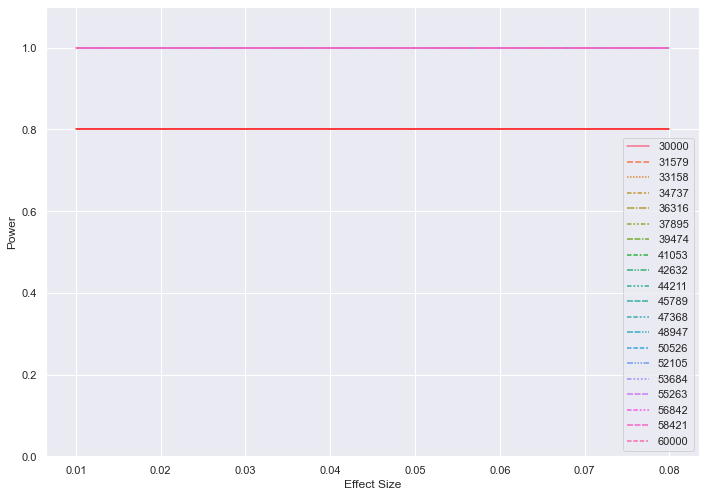

In [31]:
# Figure 1: Convergence of Power on varying Effect Sizes for percentage change in Annual Income
plot = sns.lineplot(data=inc_search.transpose())
plot.set(xlabel="Effect Size", ylabel="Power")
plt.plot([0.01, 0.08], [0.8, 0.8], c="red")
plt.ylim([0, 1.1])

leg = plot.legend(loc="lower right")
for t in leg.texts:
    # truncate label text to integer part
    t.set_text(f"{float(t.get_text()):0.0f}")

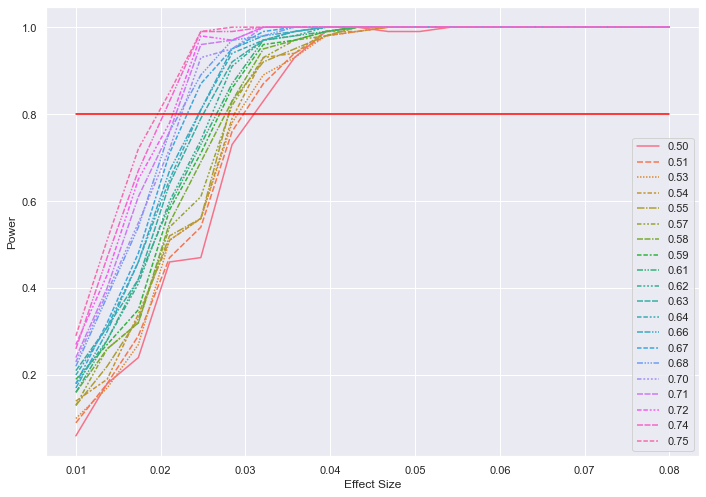

In [32]:
# Figure 2: Convergence of Power on varying Effect Sizes for percentage change in Reemployment Rate
plot = sns.lineplot(data=emp_search.transpose())
plot.set(xlabel="Effect Size", ylabel="Power")
plt.plot([0.01, 0.08], [0.8, 0.8], c="red")

leg = plot.legend()
for t in leg.texts:
    # truncate label text to 2 decimal points
    t.set_text(f"{float(t.get_text()):0.2f}")

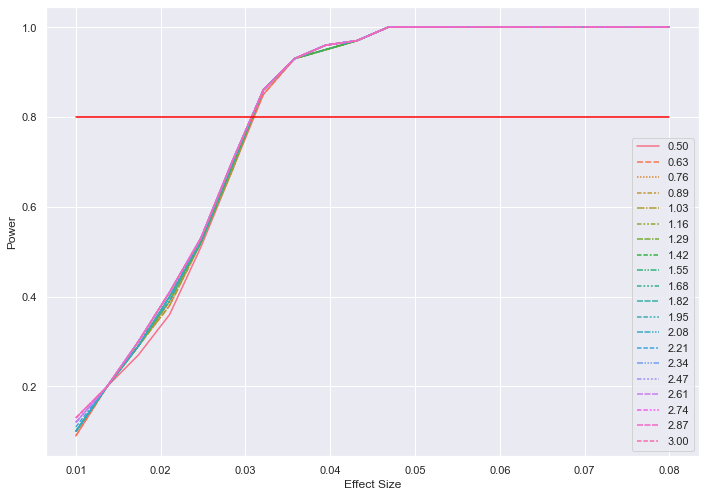

In [33]:
# Figure 3: Convergence of Power on varying Effect Sizes for percentage change in Hour to Pay Ratio
plot = sns.lineplot(data=pay_ratio_search.transpose())
plot.set(xlabel="Effect Size", ylabel="Power")
plt.plot([0.01, 0.08], [0.8, 0.8], c="red")

leg = plot.legend()
for t in leg.texts:
    # truncate label text to 2 decimal points
    t.set_text(f"{float(t.get_text()):0.2f}")

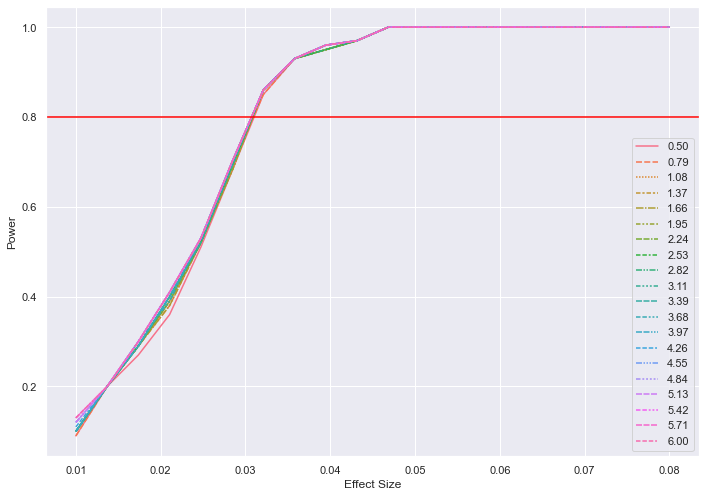

In [34]:
# Figure 4: Convergence of Power on varying Effect Sizes for percentage change in Weeks on Unemployment
plot = sns.lineplot(data=unemp_search.transpose())
plot.set(xlabel="Effect Size", ylabel="Power")
plt.axhline(y=0.8, c="red")

leg = plot.legend()
for t in leg.texts:
    # truncate label text to 2 decimal points
    t.set_text(f"{float(t.get_text()):0.2f}")